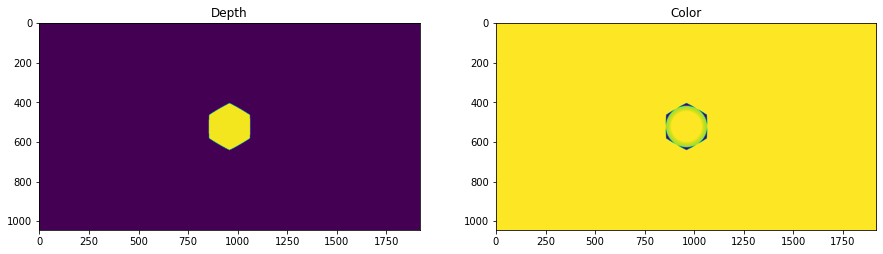

In [2]:
# read in untransformed bolt
# The untransformed location of the bolt is such that the center of the head is at 0,0,0
# and it is pointing in the direction and centered on the positive x axis.
# For example, rotating it around the z axis 90 degrees will make it appear pointing left
from utility.pose_data import get_bolt_rgbd, show_rgbd, make_pointcloud, get_random_transform
from utility.transformation_matrix import TransformationMatrix
from utility.visualizer import visualizer as vis

rgbd = get_bolt_rgbd()
show_rgbd(rgbd)

x=0.0, y=0.0, z=0.0
roll=0.0°, pitch=0.0°, yaw=90.0°


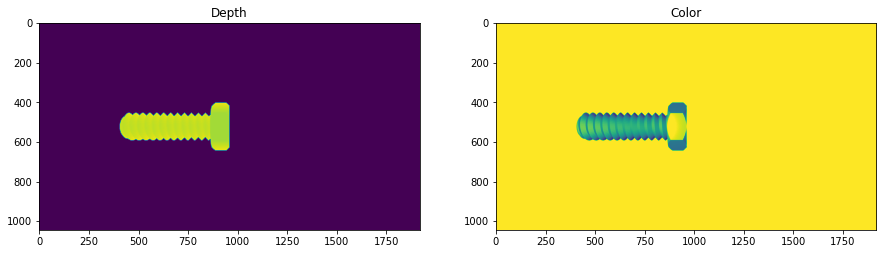

In [4]:
transform = TransformationMatrix.from_xyzwpr([0,0,0,0,0,90])
print(transform)
rgbd = get_bolt_rgbd(transform)
show_rgbd(rgbd)

x=0.0, y=-23.19, z=6.02
roll=6.27°, pitch=-9.49°, yaw=-8.33°


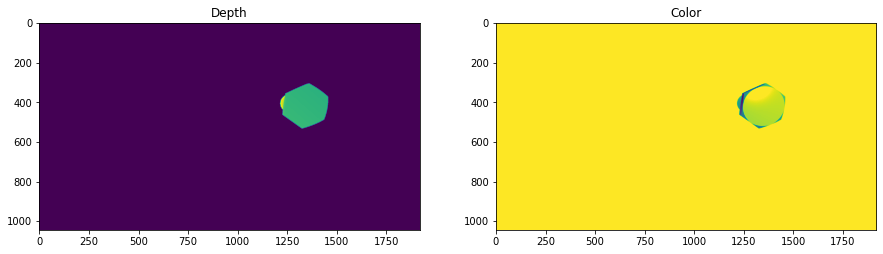

Now I'm a point cloud. Try moving me around!
Press ctrl+c to stop (or press interrupt if in jupyter)


In [5]:
transform = get_random_transform()
print(transform)
rgbd = get_bolt_rgbd(transform)
show_rgbd(rgbd)
pcd = make_pointcloud(rgbd.depth)
print('Now I\'m a point cloud. Try moving me around!')
vis.draw_geometries([pcd], moveable=True)